#Spotify Run w/Feature Importance


## Problem Definition

This model will take into account only the features identified from the previous notebook "Spotify_Project4_Baseline"

##Challenges

The challenges i see for this one is that the target could change based on running the feature with the lowest RMSE. So I have to

##Data Collection Sources

###Data Overview

###Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error


import seaborn as sns
import pickle

import graphviz
from IPython.display import display
from sklearn import tree

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import json

###File Paths

###Load Data

upload the spotify_transfer file in drive. This was created from notebook "Baseline" but commented out during construction.

In [4]:
spotify_transfer = pd.read_json( 'spotify_transfer.json', orient = "table")
spotify_transfer

,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Genre
0,48633449,3377762,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,B,"['indie rock italiano', 'italian pop']"
1,47248719,2230022,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,C#/Db,['australian hip hop']
2,40162559,6266514,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,A,['pop']
3,37799456,83293380,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,B,"['pop', 'uk pop']"
4,33948454,5473565,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,D#/Eb,"['lgbtq+ hip hop', 'pop rap']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,4630675,27167675,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,A,"['dance pop', 'pop', 'uk pop']"
1552,4623030,15019109,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,B,"['sertanejo', 'sertanejo universitario']"
1553,4620876,22698747,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,D,"['dance pop', 'electropop', 'pop', 'post-teen ..."
1554,4607385,208630,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,F,"['brega funk', 'funk carioca']"


In [5]:
spotify_transfer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Streams           1545 non-null   Int64  
 1   Artist Followers  1545 non-null   Int64  
 2   Popularity        1545 non-null   float64
 3   Danceability      1545 non-null   float64
 4   Energy            1545 non-null   float64
 5   Loudness          1545 non-null   float64
 6   Speechiness       1545 non-null   float64
 7   Acousticness      1545 non-null   float64
 8   Liveness          1545 non-null   float64
 9   Tempo             1545 non-null   float64
 10  Duration (ms)     1545 non-null   float64
 11  Valence           1545 non-null   float64
 12  Chord             1545 non-null   object 
 13  Genre             1545 non-null   object 
dtypes: Int64(2), float64(10), object(2)
memory usage: 184.1+ KB


##Data Cleaning

###Drop Columns

Dropping columns that i brought in the json that are needed only in 3rd notebook to label encode and getdummies. I will also drop the columns that is not in the list of "Important Features" from the baseline notebook results. I can continue my model here with only the feature importance to validate the features importance to the model.

In [6]:
spotify_transfer = spotify_transfer.drop(columns = ["Chord", "Genre"])
spotify_transfer = spotify_transfer.drop(columns = ["Energy", "Speechiness", "Acousticness", "Liveness", "Tempo", "Duration (ms)", "Valence"])

In [7]:
spotify_transfer.head()

,Streams,Artist Followers,Popularity,Danceability,Loudness
0,48633449,3377762,100.0,0.714,-4.808
1,47248719,2230022,99.0,0.591,-5.484
2,40162559,6266514,99.0,0.563,-5.044
3,37799456,83293380,98.0,0.808,-3.712
4,33948454,5473565,96.0,0.736,-7.409


###Check for nulls

In [8]:
spotify_transfer.isnull().sum().sum()

0

##Exploratory Data Analysis

###Feature Correlation

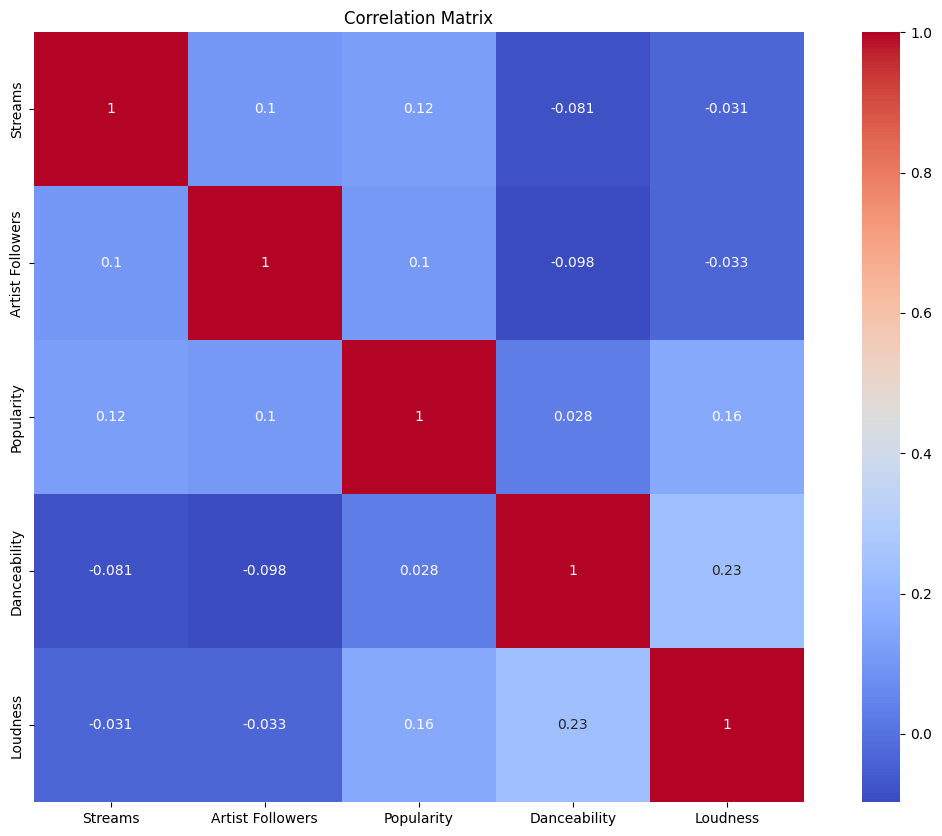

In [9]:
# Correlation matrix
correlation_matrix = spotify_transfer.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

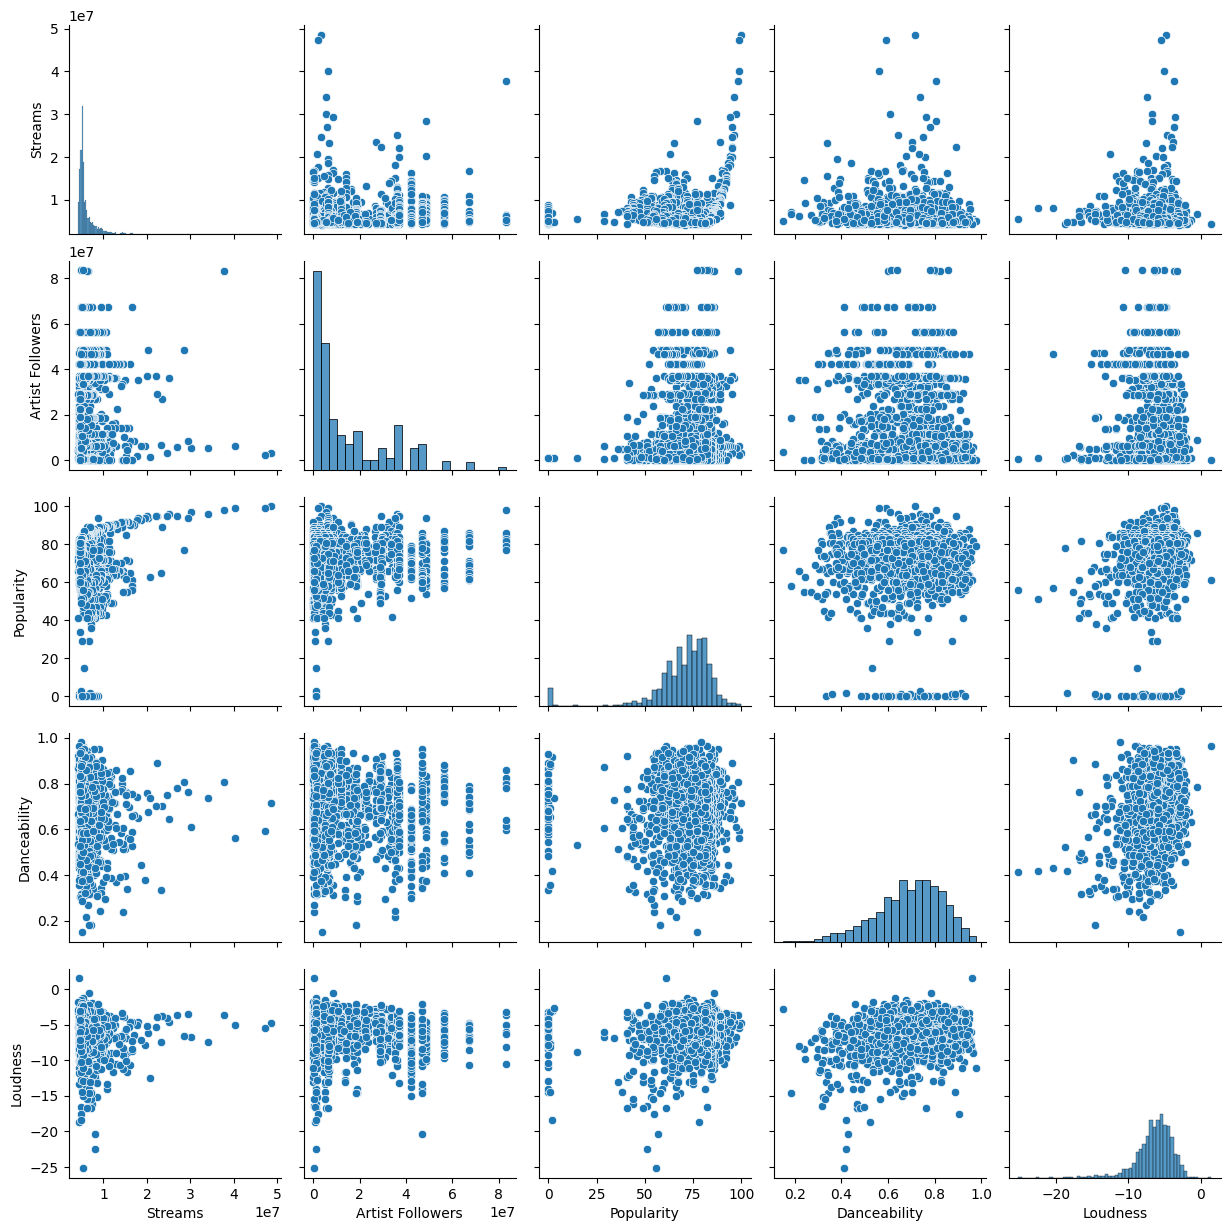

In [10]:
sns.pairplot(spotify_transfer)
plt.show()

##Data Processing

###Decision Tree

In [11]:
columns_to_iterate = spotify_transfer.columns
columns_to_iterate

Index(['Streams', 'Artist Followers', 'Popularity', 'Danceability',
       'Loudness'],
      dtype='object')

In [12]:
#I still need to work on optimizing the max depth in this loop for each feature/column
'''This model uses a max depth of 3 for each column/Feature so the max depth needs some work in this code to adjust
max depth for each column it is computing on.
'''
rmse_dict = {}

for column in columns_to_iterate:
  X = spotify_transfer.drop(column, axis = 1)
  y = spotify_transfer[column]

  numLoops = 500

  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rmse_each = rms_error.mean().round(2)
  rmse_dict[column] = rmse_each

#print(f"CV RMSE: {rms_error.mean().round(2)*1000}")
#print(f"CV RMSE: {rms_error.mean().round(2)}")
rmse_dict


{'Streams': 2087310.65,
 'Artist Followers': 16061562.76,
 'Popularity': 10.66,
 'Danceability': 0.14,
 'Loudness': 2.38}

In [13]:
s_stats = spotify_transfer.describe().transpose()
s_stats

,count,mean,std,min,25%,50%,75%,max
Streams,1545.0,6337136.377994,3375402.182363,4176083.0,4915080.0,5269163.0,6452492.0,48633449.0
Artist Followers,1545.0,14716902.866667,16675788.510875,4883.0,2123734.0,6852509.0,22698747.0,83337783.0
Popularity,1545.0,70.08932,15.824034,0.0,65.0,73.0,80.0,100.0
Danceability,1545.0,0.689997,0.142444,0.15,0.599,0.707,0.796,0.98
Loudness,1545.0,-6.348474,2.509281,-25.166,-7.491,-5.99,-4.711,1.509


In [14]:
X = spotify_transfer.drop('Popularity', axis = 1)  #this needs work to be able to populate the best column from the above rmse calcs.
y = spotify_transfer['Popularity']

In [15]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=4)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

#print(f"CV RMSE: {rms_error.mean().round(2)*1000}")
print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 10.57


This is to validate best depth value for above code block

In [16]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )

In [17]:
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) )

,0,1,2
0,1,15.262294,1.080926
1,2,10.833469,1.099189
2,3,10.702813,0.955273
3,4,10.508404,0.780217
4,5,10.727974,0.850522
5,6,10.985457,0.877115
6,7,11.208687,0.906918
7,8,11.479390,0.946357
8,9,11.751541,0.924017
9,10,12.062502,0.927450


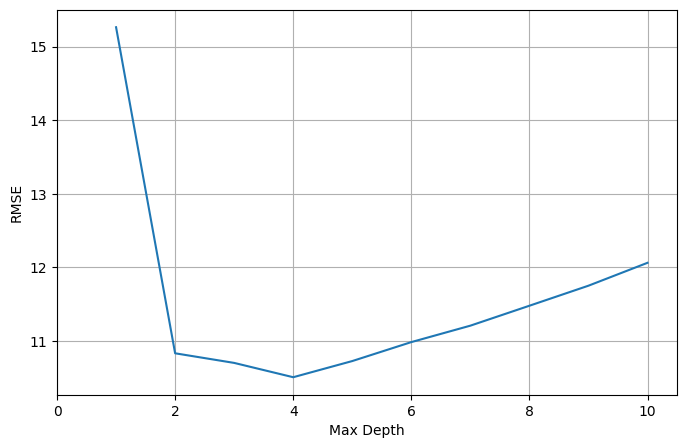

In [18]:
# Decision Tree Plot result for visualizing depth at 3 where the RMSE hinges towards a higher RMSE
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [19]:
# # Option 1
# display(
#   graphviz.Source(
#     tree.export_graphviz(
#       model,
#       feature_names = X.columns,
#       filled = True,
#     )
#   )
# )

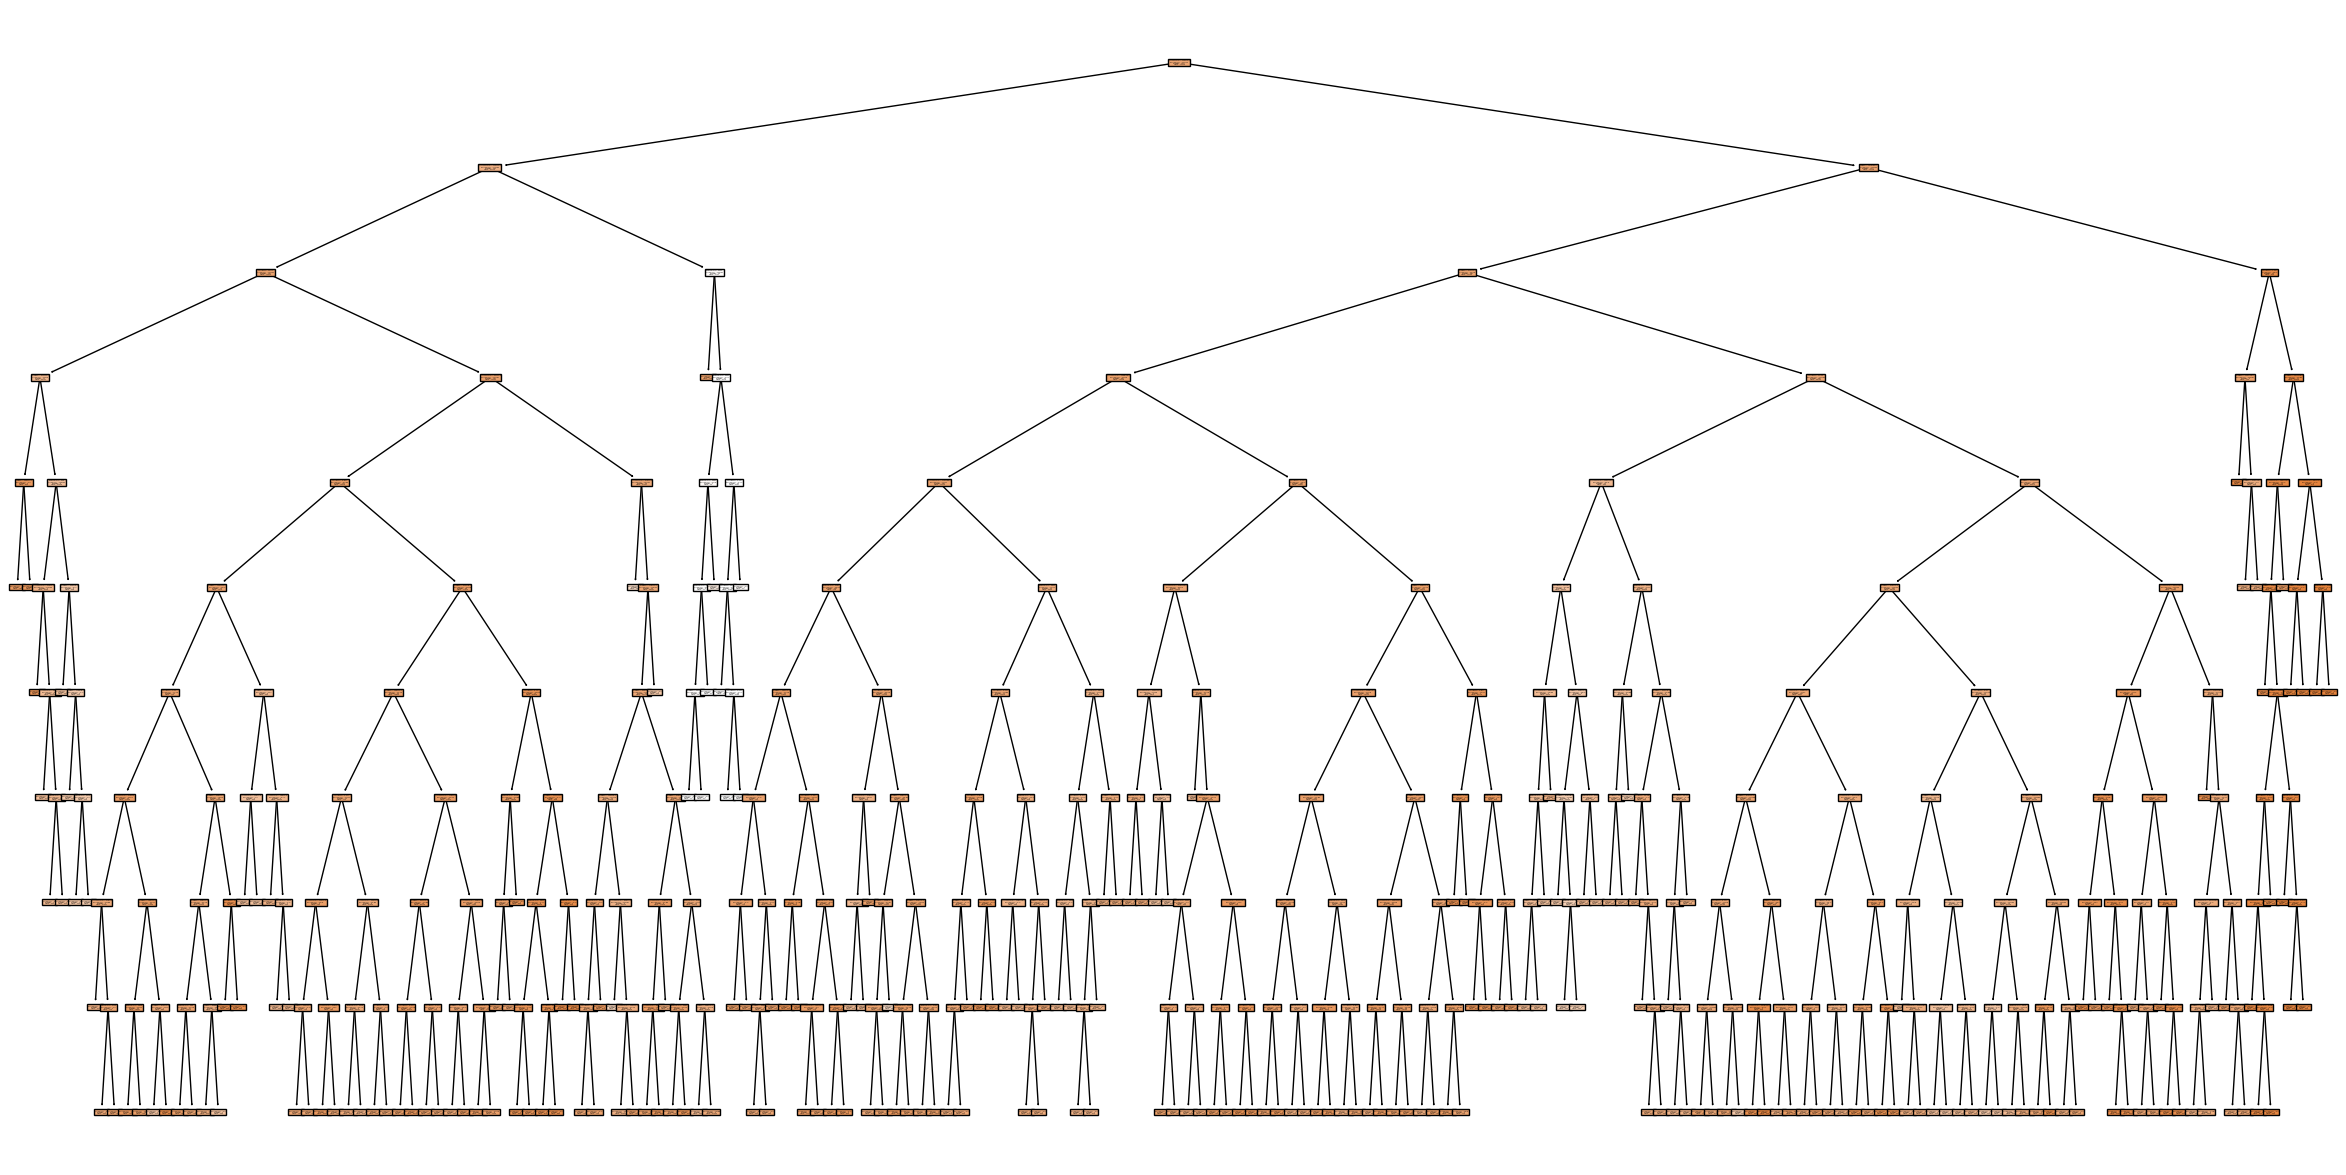

In [20]:
# Option 2
plt.figure(figsize=(30,15))
tree_plot = tree.plot_tree(
  model,
  feature_names = X.columns,
  filled=True,
)

###Random Forest

In [21]:
X = spotify_transfer.drop('Popularity', axis = 1)
y = spotify_transfer['Popularity']

In [22]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 40 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 10.272008028702933
RMSE_std: 0.7636163974387108


Here is how you decide number of trees "n_estimators"

In [23]:
num_trees = range(10,60,10)  #these numbers are the min, max, and skips for the range and this can be ajusted
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()

10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.


In [24]:
pickle.dump(rfModel, open('rfModel.p','wb'))

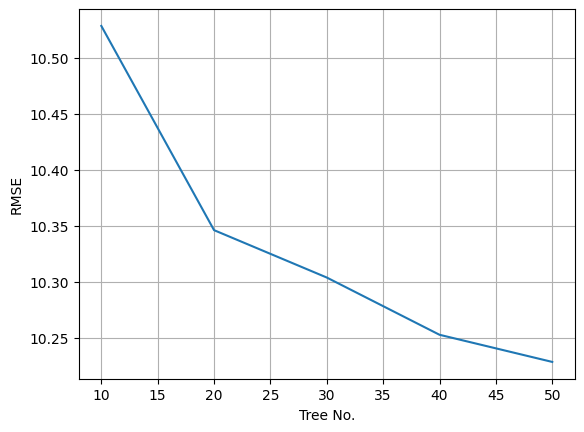

In [25]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

go plug in 40 or 50 for n_estimators in the Random Forest model to see if you get a better RMSE. You might also want to add max_depth to calibrate the best position for a better result.

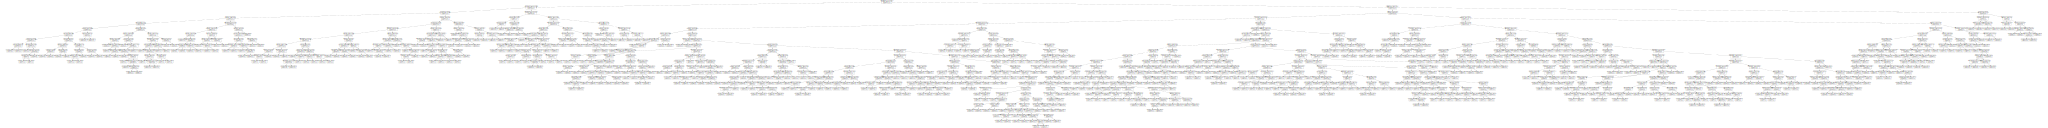

In [26]:
# Display one tree from the random forest
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[0],
      feature_names = X.columns,
    )
  )
)

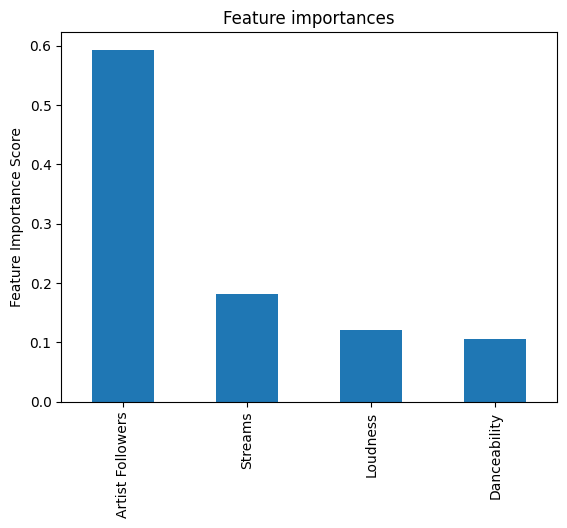

In [27]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns )

plt.figure()
# forest_importances.plot.bar()
forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Feature importances")
plt.ylabel('Feature Importance Score') ;

In [28]:
( forest_importances.sort_values( ascending = False ) * 100 ).cumsum()

Artist Followers     59.312440
Streams              77.375754
Loudness             89.371126
Danceability        100.000000
dtype: float64

###XGBoost

In [29]:
X = spotify_transfer.drop('Popularity', axis = 1)
y = spotify_transfer['Popularity']

In [35]:
spotify_transfer.columns

Index(['Streams', 'Artist Followers', 'Popularity', 'Danceability',
       'Loudness'],
      dtype='object')

In [30]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 10.747251031061749


####XGBoost with Parameters

In [31]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80}


Now we will make the adjust to our parameters and run the model again.

In [32]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1,
      max_depth = 3,
      n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

RMSE: 10.332576501153838


####Feature Importance

<ipython-input-33-16d4b8a6cfd6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


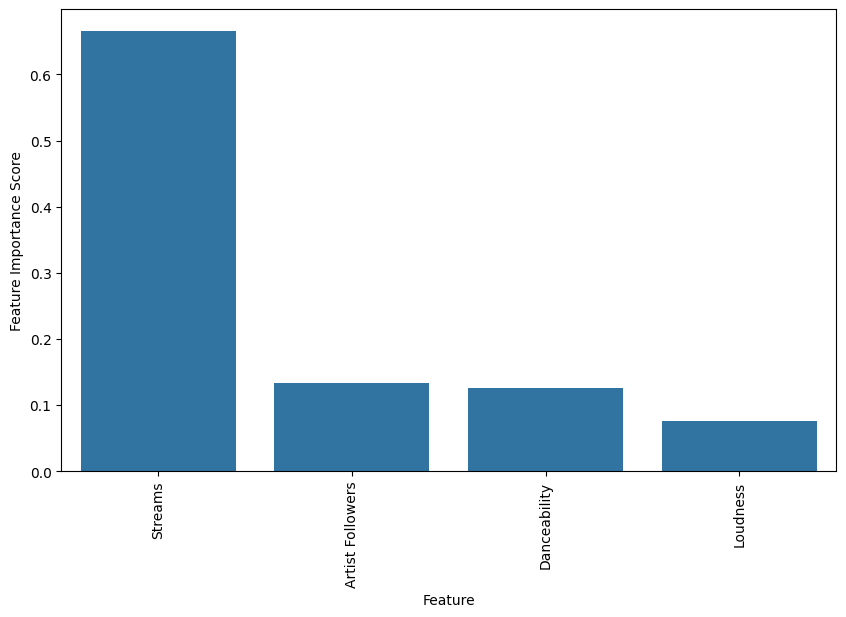

In [33]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

In [34]:
(feat_imp.sort_values( ascending = False )*100).cumsum()

Artist Followers     66.554100
Streams              79.912621
Loudness             92.478828
Danceability        100.000008
dtype: float32

#RESULTS

- Decision Tree    
  1.  RMSE:     10.53
- Random Forest
  1.  ***RMSE:    10.269767468404838***
      - RMSE_std: 0.770979819941964
- XG Boost
  1.    RMSE: 10.385331245100634